In [2]:
import pandas as pd
import numpy as np

import pickle

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt
import os
import joblib
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
main_df = pd.read_csv("main_data.csv")
estimation_df = pd.read_csv("estimation_data.csv")
oos_df = pd.read_csv("oos_data.csv")

In [6]:
# Unique PERMNOs only
unique_permnos = main_df["PERMNO"].unique()

display(unique_permnos)
display(main_df)

# Unique PERMNO and COMNAM pairs
permno_comnam_table = main_df[["PERMNO", "COMNAM","Category"]].drop_duplicates().reset_index(drop=True)

print(permno_comnam_table)

array([11174, 20512, 29647, 39731, 40125, 44644, 44943, 45911, 47466,
       47941, 50286, 55993, 61241, 63773, 66093, 75104, 75320, 76226,
       78405, 78840, 78971, 79033, 79879, 80089, 80924, 81043, 81132,
       81133, 81740, 82281, 82646, 82924, 82932, 83604, 83989, 84176,
       85177, 85442, 86047, 86051, 86144, 86745, 86776, 86869, 86916,
       86929, 86996, 87075, 87179, 87344])

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,Category,rf,EXCESS_RET,market_cap,rolling_mean_5,rolling_mean_21,rolling_mean_252,rolling_mean_512,EXCESS_RET_lag_1,EXCESS_RET_lag_2,EXCESS_RET_lag_3,EXCESS_RET_lag_4,EXCESS_RET_lag_5
0,11174,2000-01-03,4840.0,CROWN GROUP INC,5.10938,0.034810,9711.0,Telecom & Cable,0.00021,0.034600,49617189.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11174,2000-01-04,4840.0,CROWN GROUP INC,5.00000,-0.021407,9711.0,Telecom & Cable,0.00021,-0.021617,48555000.00,NaN,NaN,NaN,NaN,0.034600,NaN,NaN,NaN,NaN
2,11174,2000-01-05,4840.0,CROWN GROUP INC,4.87500,-0.025000,9711.0,Telecom & Cable,0.00021,-0.025210,47341125.00,NaN,NaN,NaN,NaN,-0.021617,0.034600,NaN,NaN,NaN
3,11174,2000-01-06,4840.0,CROWN GROUP INC,5.18750,0.064103,9711.0,Telecom & Cable,0.00021,0.063893,50375812.50,NaN,NaN,NaN,NaN,-0.025210,-0.021617,0.034600,NaN,NaN
4,11174,2000-01-07,4840.0,CROWN GROUP INC,4.75000,-0.084337,9711.0,Telecom & Cable,0.00021,-0.084547,46127250.00,NaN,NaN,NaN,NaN,0.063893,-0.025210,-0.021617,0.034600,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314445,87344,2024-12-24,7370.0,SIFY TECHNOLOGIES LTD,3.02000,0.016835,11779.0,Internet & Software,0.00017,0.016665,35572580.00,-0.011826,-0.005351,-0.002356,0.000115,-0.000170,0.023968,-0.070683,-0.034226,0.021982
314446,87344,2024-12-26,7370.0,SIFY TECHNOLOGIES LTD,3.19000,0.056291,11779.0,Internet & Software,0.00017,0.056121,37575010.00,-0.012889,-0.004832,-0.002185,0.000162,0.016665,-0.000170,0.023968,-0.070683,-0.034226
314447,87344,2024-12-27,7370.0,SIFY TECHNOLOGIES LTD,3.16000,-0.009404,11779.0,Internet & Software,0.00017,-0.009574,37221640.00,0.005180,-0.003422,-0.001940,0.000316,0.056121,0.016665,-0.000170,0.023968,-0.070683
314448,87344,2024-12-30,7370.0,SIFY TECHNOLOGIES LTD,2.89000,-0.085443,11779.0,Internet & Software,0.00017,-0.085613,34041310.00,0.017402,-0.005107,-0.001869,0.000357,-0.009574,0.056121,0.016665,-0.000170,0.023968


    PERMNO                           COMNAM             Category
0    11174                  CROWN GROUP INC      Telecom & Cable
1    11174            AMERICAS CAR MART INC      Telecom & Cable
2    20512           CACI INTERNATIONAL INC  Internet & Software
3    29647                        B C E INC      Telecom & Cable
4    39731  GRAY COMMUNICATIONS SYSTEMS INC      Telecom & Cable
..     ...                              ...                  ...
89   87075                   ZIFF DAVIS INC      Telecom & Cable
90   87179             NETSCOUT SYSTEMS INC  Internet & Software
91   87344               SATYAM INFOWAY LTD  Internet & Software
92   87344                         SIFY LTD  Internet & Software
93   87344            SIFY TECHNOLOGIES LTD  Internet & Software

[94 rows x 3 columns]


In [10]:
trading_days_count = main_df.groupby('PERMNO').size()
display(len(trading_days_count))

50

In [12]:
# Drop missing values first
valid_returns = oos_df['EXCESS_RET'].dropna()

# Count negative and positive days
neg_count = (valid_returns < 0).sum()
pos_count = (valid_returns > 0).sum()
zero_count = (valid_returns == 0).sum()
total = len(valid_returns)

# Proportions
neg_pct = neg_count / total * 100
pos_pct = pos_count / total * 100
zero_pct = zero_count / total * 100

# Display
print(f"📉 Negative return days: {neg_count} ({neg_pct:.2f}%)")
print(f"📈 Positive return days: {pos_count} ({pos_pct:.2f}%)")
print(f"⚖️  Zero return days:     {zero_count} ({zero_pct:.2f}%)")
print(f"📊 Total valid days:      {total}")


📉 Negative return days: 56408 (49.83%)
📈 Positive return days: 56467 (49.88%)
⚖️  Zero return days:     325 (0.29%)
📊 Total valid days:      113200


In [15]:

def directional_up_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    up_mask = y_true[1:] > y_true[:-1]
    pred_up_mask = y_pred[1:] > y_pred[:-1]
    correct_up = (up_mask & pred_up_mask).sum()
    total_up = up_mask.sum()
    return correct_up / total_up if total_up != 0 else np.nan

def directional_down_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    down_mask = y_true[1:] < y_true[:-1]
    pred_down_mask = y_pred[1:] < y_pred[:-1]
    correct_down = (down_mask & pred_down_mask).sum()
    total_down = down_mask.sum()
    return correct_down / total_down if total_down != 0 else np.nan

# Function for directional accuracy
def directional_accuracy(y_true, y_pred):
    actual_diff = y_true.values[1:] - y_true.values[:-1]
    predicted_diff = y_pred[1:] - y_pred[:-1]
    return (actual_diff * predicted_diff > 0).sum() / len(actual_diff)

# Directional accuracy functions
def directional_up_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    up_mask = y_true[1:] > y_true[:-1]
    pred_up_mask = y_pred[1:] > y_pred[:-1]
    correct_up = (up_mask & pred_up_mask).sum()
    total_up = up_mask.sum()
    return correct_up / total_up if total_up != 0 else np.nan

def directional_down_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    down_mask = y_true[1:] < y_true[:-1]
    pred_down_mask = y_pred[1:] < y_pred[:-1]
    correct_down = (down_mask & pred_down_mask).sum()
    total_down = down_mask.sum()
    return correct_down / total_down if total_down != 0 else np.nan



USED PICKLE FOR ERROR METRIC

In [12]:

LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
model_names = ["OLS", "Ridge", "Lasso", "PLS", "PCR"]
pickle_dir = "SavedPickleModels"

# Ensure the pickle directory exists
os.makedirs(pickle_dir, exist_ok=True)

# Model dictionary
model_dict = {
    "OLS": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge()),
    "Lasso": make_pipeline(StandardScaler(), Lasso(alpha=1e-5)),
    "PLS": PLSRegression(n_components=min(len(lag_features) + 1, 5)),
    "PCR": make_pipeline(StandardScaler(), PCA(n_components=min(len(lag_features) + 1, 5)), LinearRegression())
    # "RF": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
}

# Loop over each rolling window
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    train = estimation_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_train = train[feature_set]
    y_train = train['EXCESS_RET']
    for name in model_names:
        model = model_dict[name]

        # Fit model
        model.fit(X_train, y_train)

        # Save model
        model_path = os.path.join(pickle_dir, f"{name}_window{w}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

        print(f"Saved: {model_path}")


Saved: SavedPickleModels\OLS_window5.pkl
Saved: SavedPickleModels\Ridge_window5.pkl
Saved: SavedPickleModels\Lasso_window5.pkl
Saved: SavedPickleModels\PLS_window5.pkl
Saved: SavedPickleModels\PCR_window5.pkl
Saved: SavedPickleModels\OLS_window21.pkl
Saved: SavedPickleModels\Ridge_window21.pkl
Saved: SavedPickleModels\Lasso_window21.pkl
Saved: SavedPickleModels\PLS_window21.pkl
Saved: SavedPickleModels\PCR_window21.pkl
Saved: SavedPickleModels\OLS_window252.pkl
Saved: SavedPickleModels\Ridge_window252.pkl
Saved: SavedPickleModels\Lasso_window252.pkl
Saved: SavedPickleModels\PLS_window252.pkl
Saved: SavedPickleModels\PCR_window252.pkl
Saved: SavedPickleModels\OLS_window512.pkl
Saved: SavedPickleModels\Ridge_window512.pkl
Saved: SavedPickleModels\Lasso_window512.pkl
Saved: SavedPickleModels\PLS_window512.pkl
Saved: SavedPickleModels\PCR_window512.pkl


In [19]:
import os
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# === Parameters ===
LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
pickle_dir = "SavedPickleModels"

# Make sure the directory exists
os.makedirs(pickle_dir, exist_ok=True)

# === Define Random Forest only ===
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# === Loop over each rolling window ===
for w in rolling_windows:
    print(w)
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    train = estimation_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_train = train[feature_set]
    y_train = train['EXCESS_RET']

    # Fit Random Forest
    rf_model.fit(X_train, y_train)

    # Save the model
    model_path = os.path.join(pickle_dir, f"RF_window{w}.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(rf_model, f)

    print(f"✅ Saved RF model for window {w} to: {model_path}")


5
✅ Saved RF model for window 5 to: SavedPickleModels\RF_window5.pkl
21
✅ Saved RF model for window 21 to: SavedPickleModels\RF_window21.pkl
252
✅ Saved RF model for window 252 to: SavedPickleModels\RF_window252.pkl
512
✅ Saved RF model for window 512 to: SavedPickleModels\RF_window512.pkl


In [16]:

LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
model_names = ["OLS", "Ridge", "Lasso", "PLS", "PCR", "RF"]
pickle_dir = "SavedPickleModels"
# estimation_df as training data  
# oos_df as test data 

# Results container
results = []
oos_df_pred = oos_df.copy()

# Loop through windows and model files
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    test = oos_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_test = test[feature_set]
    y_test = test['EXCESS_RET']

    for name in model_names:
        model_path = os.path.join(pickle_dir, f"{name}_window{w}.pkl")
        pred_col = f"{name}_predicted_window{w}"
        
        if not os.path.exists(model_path):
            print(f"Model {name}_window{w}.pkl not found. Skipping.")
            continue

        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            preds = model.predict(X_test)
            test_temp = test[['PERMNO', 'date']].copy()
            test_temp[pred_col] = preds

            oos_df_pred = oos_df_pred.merge(test_temp, on=['PERMNO', 'date'], how='left')
            results.append({
                'Model': name,
                'Rolling Window': w,
                'R2': r2_score(y_test, preds),
                'MSE': mean_squared_error(y_test, preds),
                'MAE': mean_absolute_error(y_test, preds),
                'Directional Accuracy': directional_accuracy(y_test, preds),
                'Directional Up': directional_up_accuracy(y_test, preds),
                'Directional Down': directional_down_accuracy(y_test, preds)
            })

        except Exception as e:
            results.append({
                'Model': name,
                'Rolling Window': w,
                'R2': np.nan,
                'MSE': np.nan,
                'MAE': np.nan,
                'Directional Accuracy': np.nan,
                'Directional Up': np.nan,
                'Directional Down': np.nan,
                'Error': str(e)
            })
# === Collect all prediction column names ===
model_pred_cols = [f"{name}_predicted_window{w}" for name in model_names for w in rolling_windows]

# === Final DataFrame to save: only relevant columns ===
cols_to_keep = ['PERMNO', 'date', 'EXCESS_RET'] + [col for col in model_pred_cols if col in oos_df_pred.columns]
oos_df_pred_trimmed = oos_df_pred[cols_to_keep].copy()

import re

# Assume df is your DataFrame with all model predictions
rename_dict = {
    col: re.sub(r'_predicted_window', '_', col)
    for col in oos_df_pred_trimmed.columns if '_predicted_window' in col
}

oos_df_pred_trimmed.rename(columns=rename_dict, inplace=True)

display(oos_df_pred_trimmed)
# === Save results ===
os.makedirs("Results", exist_ok=True)

oos_df_pred_trimmed.to_csv("Results/linear_predictions.csv", index=False)
print("✅ Saved trimmed predictions to Results/linear_predictions.csv")

results_linear_df = pd.DataFrame(results)
results_linear_df.to_csv("Results/linear_metrics.csv", index=False)
display(results_linear_df)
print("✅ Saved metrics to Results/linear_metrics.csv")


,PERMNO,date,EXCESS_RET,OLS_5,OLS_21,OLS_252,OLS_512,Ridge_5,Ridge_21,Ridge_252,...,PLS_252,PLS_512,PCR_5,PCR_21,PCR_252,PCR_512,RF_5,RF_21,RF_252,RF_512
0,11174,2016-01-04,0.025478,0.001392,0.001581,0.001567,0.002172,0.001392,0.001581,0.001567,...,0.001567,0.002172,0.001392,0.001137,0.001681,0.002079,-0.004580,-0.007563,0.001125,-0.000822
1,11174,2016-01-05,0.002192,0.001043,0.001017,0.000461,0.000417,0.001043,0.001017,0.000461,...,0.000461,0.000417,0.001043,0.000939,0.000858,0.000563,-0.003808,0.010210,0.002047,0.004193
2,11174,2016-01-06,-0.060518,0.000286,0.000330,-0.000153,0.000340,0.000286,0.000330,-0.000153,...,-0.000153,0.000340,0.000286,0.000199,0.000173,0.000430,-0.004649,0.000334,0.000401,-0.000619
3,11174,2016-01-07,-0.008925,0.000520,0.000631,0.000764,0.001876,0.000520,0.000631,0.000764,...,0.000764,0.001876,0.000520,0.000292,0.000829,0.001726,-0.006162,-0.008249,-0.014279,-0.012642
4,11174,2016-01-08,-0.020360,0.001990,0.002023,0.001854,0.002040,0.001990,0.002023,0.001854,...,0.001854,0.002040,0.001990,0.001704,0.001931,0.001877,-0.006983,-0.000312,-0.002638,-0.014208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113195,87344,2024-12-24,0.016665,0.000440,0.000312,-0.000195,0.000447,0.000440,0.000312,-0.000195,...,-0.000195,0.000447,0.000440,0.000289,-0.000141,0.000127,-0.007997,0.001294,-0.004799,-0.007629
113196,87344,2024-12-26,0.056121,-0.000401,-0.000470,-0.000870,-0.000676,-0.000401,-0.000470,-0.000870,...,-0.000870,-0.000676,-0.000401,-0.000536,-0.000816,-0.000951,-0.006949,-0.001845,0.004884,-0.004818
113197,87344,2024-12-27,-0.009574,0.000313,0.000162,-0.000176,-0.000615,0.000313,0.000162,-0.000176,...,-0.000176,-0.000615,0.000313,0.000513,0.000321,-0.000403,0.000395,0.006507,0.004586,-0.000927
113198,87344,2024-12-30,-0.085613,-0.000516,-0.000808,-0.000574,0.000041,-0.000516,-0.000808,-0.000574,...,-0.000574,0.000041,-0.000516,-0.000047,0.000216,0.000557,-0.010262,-0.002024,-0.008528,-0.015458


✅ Saved trimmed predictions to Results/linear_predictions.csv


,Model,Rolling Window,R2,MSE,MAE,Directional Accuracy,Directional Up,Directional Down
0,OLS,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
1,Ridge,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
2,Lasso,5,-0.002366,0.001067,0.018193,0.571401,0.573689,0.571311
3,PLS,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
4,PCR,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
5,RF,5,-0.052553,0.001121,0.018859,0.484280,0.485455,0.484953
6,OLS,21,-0.002475,0.001068,0.018194,0.576957,0.579965,0.576184
7,Ridge,21,-0.002475,0.001068,0.018194,0.576957,0.579965,0.576184
8,Lasso,21,-0.002392,0.001067,0.018194,0.576869,0.579607,0.576359
9,PLS,21,-0.002475,0.001068,0.018194,0.576957,0.579965,0.576184


✅ Saved metrics to Results/linear_metrics.csv


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === CONFIG ===
LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
pickle_dir = "SavedTorchModels"
os.makedirs(pickle_dir, exist_ok=True)

# === Sample Estimation DataFrame Assumed Preloaded ===
# estimation_df = ... (must contain 'EXCESS_RET', lag features, and rolling_mean_*)

# === Feedforward Neural Network Definition ===
class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, 32))
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(32, 32))
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output(x)

# === Training and Saving Loop ===
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    # Drop rows with missing values for this feature set
    train = estimation_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_train = train[feature_set].values.astype(np.float32)
    y_train = train['EXCESS_RET'].values.astype(np.float32).reshape(-1, 1)

    print(f"\n=== Training Models for Window {w} ===")
    
    for n_layers in range(1, 6):  # NN1 to NN5
        print(f'Starting layer {n_layers}')
        model = FeedforwardNet(input_dim=X_train.shape[1], n_layers=n_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()

        # Train for 50 epochs
        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            preds = model(torch.from_numpy(X_train))
            loss = loss_fn(preds, torch.from_numpy(y_train))
            loss.backward()
            optimizer.step()

        # Save model weights and metadata
        model_path = os.path.join(pickle_dir, f"NN{n_layers}_window{w}.pt")
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': X_train.shape[1],
            'n_layers': n_layers
        }, model_path)

        print(f"Saved: {model_path}")



=== Training Models for Window 5 ===
Starting layer 1
Saved: SavedTorchModels\NN1_window5.pt
Starting layer 2
Saved: SavedTorchModels\NN2_window5.pt
Starting layer 3
Saved: SavedTorchModels\NN3_window5.pt
Starting layer 4
Saved: SavedTorchModels\NN4_window5.pt
Starting layer 5
Saved: SavedTorchModels\NN5_window5.pt

=== Training Models for Window 21 ===
Starting layer 1
Saved: SavedTorchModels\NN1_window21.pt
Starting layer 2
Saved: SavedTorchModels\NN2_window21.pt
Starting layer 3
Saved: SavedTorchModels\NN3_window21.pt
Starting layer 4
Saved: SavedTorchModels\NN4_window21.pt
Starting layer 5
Saved: SavedTorchModels\NN5_window21.pt

=== Training Models for Window 252 ===
Starting layer 1


KeyboardInterrupt: 

PREDICTION NEURAL NETWORK

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

df = pd.read_csv("oos_data.csv")
# === Parameters ===
TARGET = "EXCESS_RET"
LAGS = 5
WINDOWS = [5, 21, 252, 512]
LAYER_COUNTS = [1, 2, 3, 4, 5]
MODEL_DIR = "SavedTorchModels"           # Path to your out-of-sample data
SAVE_PATH = "Results/nn_predictions.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Load and prepare OOS data ===
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["PERMNO", "date"]).reset_index(drop=True)
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")

# === FeedforwardNet (same as training) ===
class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, 32))
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(32, 32))
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output(x).squeeze(-1)

# === Final output DataFrame ===
final_df = df[["PERMNO", "date", TARGET]].copy()

# === Predict with each model ===
for w in WINDOWS:
    feature_cols = [f"{TARGET}_lag_{i}" for i in range(1, LAGS + 1)] + [f"rolling_mean_{w}"]
    valid_mask = df[feature_cols].notna().all(axis=1)

    if valid_mask.sum() == 0:
        print(f"⚠️ No valid rows for window {w}. Skipping.")
        continue
    
    scaler_path = f"SavedTorchModels/NN{n_layers}_window{w}_scaler.pkl"
    with open(scaler_path, "rb") as f:
        feature_scaler = pickle.load(f)

    X_all = df.loc[valid_mask, feature_cols].astype(np.float32).values
    X_scaled = feature_scaler.transform(X_all)
    X_torch = torch.from_numpy(X_scaled).to(device)

    for x in LAYER_COUNTS:
        model_path = os.path.join(MODEL_DIR, f"NN{x}_window{w}.pt")
        colname = f"NN{x}_{w}"

        if not os.path.exists(model_path):
            print(f"❌ Model not found: {model_path}")
            continue

        print(f"✓ Predicting: {colname}")
        # Load model
        model = FeedforwardNet(input_dim=X_torch.shape[1], n_layers=x).to(device)
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get("model_state_dict", checkpoint)
        model.load_state_dict(state_dict, strict=False)
        model.eval()

        # Predict
        with torch.no_grad():
            preds = model(X_torch).cpu().numpy()

        # Fill predictions
        final_df[colname] = np.nan
        final_df.loc[valid_mask, colname] = preds

# === Save ===
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
final_df["date"] = final_df["date"].dt.strftime("%Y-%m-%d")
final_df.to_csv(SAVE_PATH, index=False)
print(f"✅ All predictions saved to: {SAVE_PATH}")


Using device: cpu


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === Helper directional metrics ===
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def directional_up_accuracy(y_true, y_pred):
    mask = y_true > 0
    return np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])) if mask.any() else np.nan

def directional_down_accuracy(y_true, y_pred):
    mask = y_true < 0
    return np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])) if mask.any() else np.nan

# === Load predicted file ===
df = pd.read_csv("Results/nn_predictions.csv")
df["date"] = pd.to_datetime(df["date"])
df["EXCESS_RET"] = pd.to_numeric(df["EXCESS_RET"], errors="coerce")

# === Get list of prediction columns ===
pred_cols = [col for col in df.columns if col.startswith("NN")]

# === Metric results container ===
results = []

for col in pred_cols:
    try:
        y_true = df["EXCESS_RET"].copy()
        y_pred = df[col].copy()

        # Drop missing values
        valid = y_true.notna() & y_pred.notna()
        y_true = y_true[valid]
        y_pred = y_pred[valid]

        if len(y_true) < 10:
            continue  # too few valid rows

        # Extract layer and window from column name
        parts = col.replace("NN", "").split("_")
        layers = int(parts[0])
        window = int(parts[1])

        results.append({
            'Model': f'NN{layers}',
            'Rolling Window': window,
            'R2': r2_score(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'Directional Accuracy': directional_accuracy(y_true, y_pred),
            'Directional Up': directional_up_accuracy(y_true, y_pred),
            'Directional Down': directional_down_accuracy(y_true, y_pred)
        })

    except Exception as e:
        print(f"⚠️ Failed to compute metrics for {col}: {e}")

# === Save results ===
results_df = pd.DataFrame(results).sort_values(["Rolling Window", "Model"])
display(results_df)
results_df.to_csv("Results/nn_metrics.csv", index=False)
print("✅ Saved metrics to: Results/nn_metrics.csv")
print(results_df.head())


,Model,Rolling Window,R2,MSE,MAE,Directional Accuracy,Directional Up,Directional Down
0,NN1,5,-0.041076,0.001109,0.018275,0.499152,0.988737,0.011931
1,NN2,5,-0.050556,0.001119,0.018280,0.494664,0.067491,0.925135
2,NN3,5,-0.027381,0.001094,0.018302,0.496069,0.045602,0.949865
3,NN4,5,-0.039606,0.001107,0.018326,0.499797,0.983849,0.018118
4,NN5,5,-0.029579,0.001096,0.018301,0.499019,0.997379,0.003014
5,NN1,21,-0.019967,0.001086,0.018233,0.491440,0.325323,0.660562
6,NN2,21,-0.042100,0.001110,0.018506,0.499134,0.997698,0.002925
7,NN3,21,-0.053013,0.001121,0.018256,0.500459,0.936494,0.066852
8,NN4,21,-0.016420,0.001082,0.018216,0.497085,0.053093,0.944405
9,NN5,21,-0.019303,0.001085,0.018218,0.499700,0.991198,0.010566


✅ Saved metrics to: Results/nn_metrics.csv
  Model  Rolling Window        R2       MSE       MAE  Directional Accuracy  \
0   NN1               5 -0.041076  0.001109  0.018275              0.499152   
1   NN2               5 -0.050556  0.001119  0.018280              0.494664   
2   NN3               5 -0.027381  0.001094  0.018302              0.496069   
3   NN4               5 -0.039606  0.001107  0.018326              0.499797   
4   NN5               5 -0.029579  0.001096  0.018301              0.499019   

   Directional Up  Directional Down  
0        0.988737          0.011931  
1        0.067491          0.925135  
2        0.045602          0.949865  
3        0.983849          0.018118  
4        0.997379          0.003014  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predicted data
df = pd.read_csv("Results/oos_all_nn_pred.csv")
df['date'] = pd.to_datetime(df['date'])
df_pred_nn = pd.read_csv("results_oos_pred_nn.csv")
df_pred_nn['date'] = pd.to_datetime(df_pred_nn['date'])

df_pred_subset = df_pred_nn[['PERMNO', 'date'] + list(df_pred_nn.columns[-20:])]

df_merged = pd.merge(df, df_pred_subset, on=['PERMNO', 'date'], how='left')
print(df_merged.columns)
display(df_merged.head())
# Config
percentile = 0.2
predicted_cols = [col for col in df_merged.columns if col.endswith("5")]
strategy_names = ['LONG_ONLY', 'SHORT_ONLY', 'LONG_SHORT', 'TOP_MINUS_REST']

# Initialize dictionary to store cumulative returns for each strategy
strategy_cum_returns = {strategy: pd.DataFrame() for strategy in strategy_names}

for col in predicted_cols:
    model_name = col.replace('5', '')
    temp = df_merged[['date', 'PERMNO', 'EXCESS_RET', col]].copy()
    temp.rename(columns={col: 'PRED'}, inplace=True)

    temp['RANK'] = temp.groupby('date')['PRED'].transform(lambda x: x.rank(pct=True))

    temp['LONG_ONLY'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], np.nan)
    temp['SHORT_ONLY'] = np.where(temp['RANK'] <= percentile, -temp['EXCESS_RET'], np.nan)
    temp['LONG_SHORT'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], 0) + \
                         np.where(temp['RANK'] <= percentile, -temp['EXCESS_RET'], 0)
    temp['TOP_MINUS_REST'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], 0) - \
                             np.where((temp['RANK'] < 1 - percentile), temp['EXCESS_RET'], 0)

    # Group by date and compute daily mean returns
    daily_returns = temp.groupby('date')[strategy_names].mean()
    cumulative_returns = (1 + daily_returns.fillna(0)).cumprod()

    for strategy in strategy_names:
        strategy_cum_returns[strategy][model_name] = cumulative_returns[strategy]

# Plot all models in each strategy
import os
os.makedirs("Results", exist_ok=True)

for strategy in strategy_names:
    plt.figure(figsize=(12, 6))
    for model in strategy_cum_returns[strategy].columns:
        plt.plot(strategy_cum_returns[strategy].index, strategy_cum_returns[strategy][model], label=model)
    plt.title(f'Cumulative Returns - {strategy.replace("_", " ").title()}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"Results/cumulative_{strategy.lower()}.png")
    plt.close()

print("All 4 strategy graphs saved in 'Results' folder.")


ValueError: The column label 'PERMNO' is not unique.

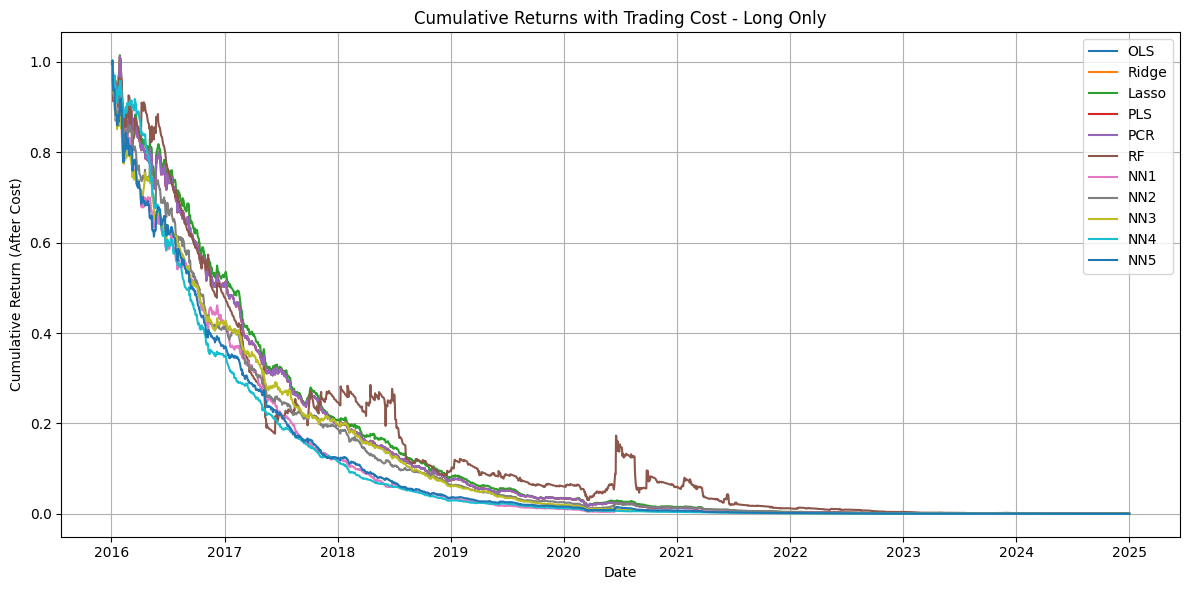

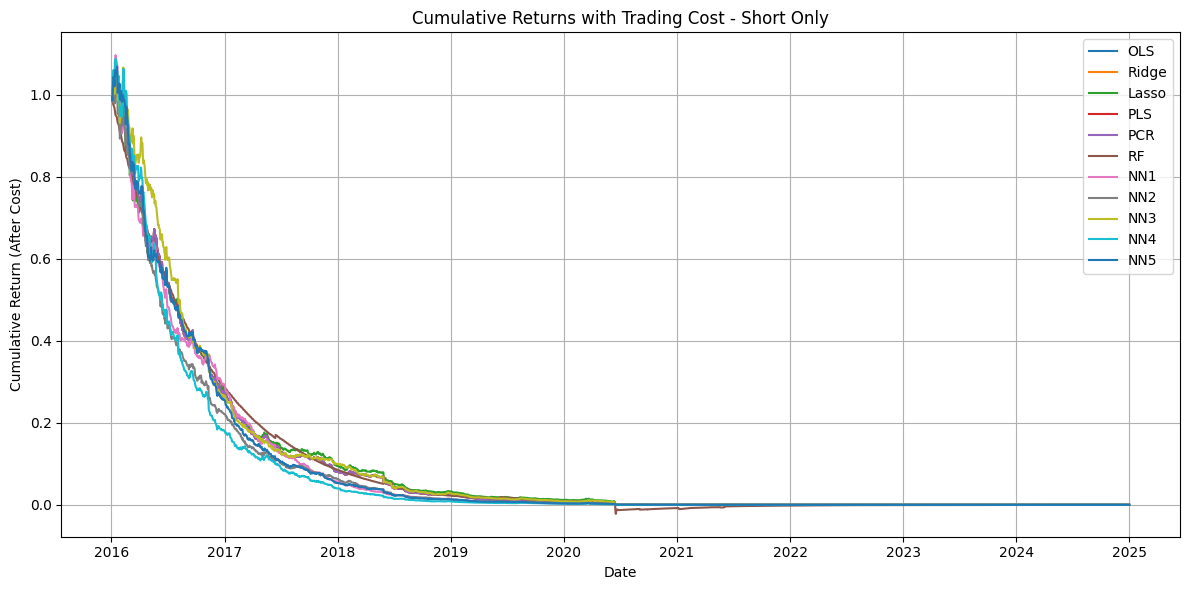

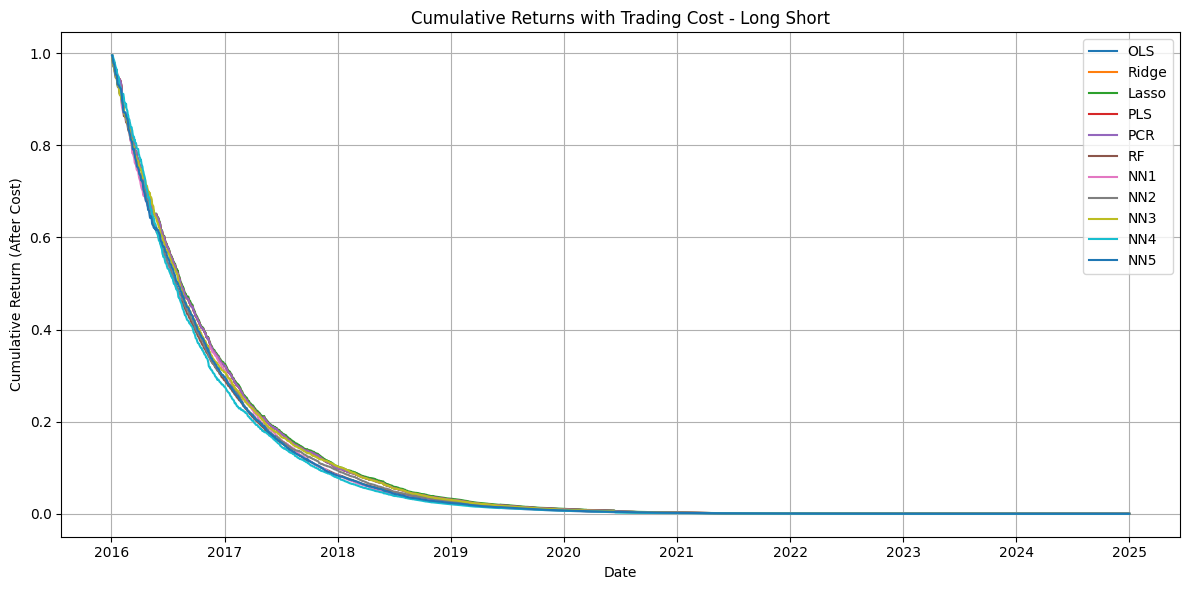

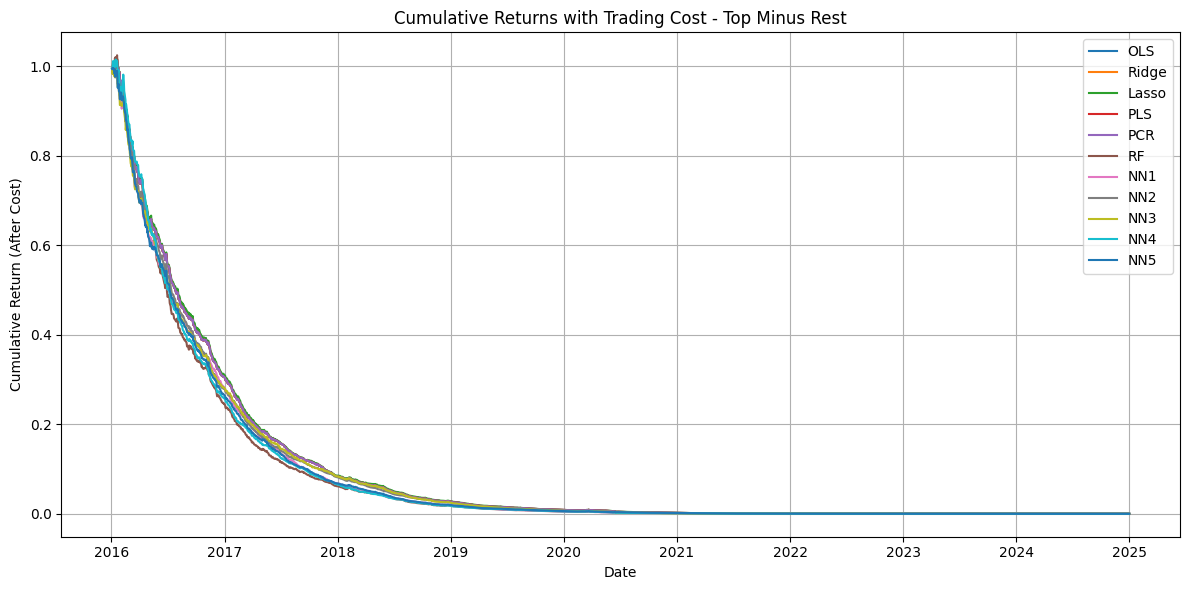

In [12]:
TRADING_COST_PER_SIDE = 0.0025  # 0.25%
DAILY_COST = TRADING_COST_PER_SIDE * 2  # Round-trip

for strategy in strategy_names:
    raw = strategy_cum_returns[strategy]
    cost_adj = raw.copy()

    # Apply constant daily cost to each active strategy
    for model in raw.columns:
        daily_returns = raw[model].pct_change().fillna(0)
        net_returns = daily_returns - DAILY_COST
        cost_adj[model] = (1 + net_returns).cumprod()

    # Plot with trading cost
    plt.figure(figsize=(12, 6))
    for model in cost_adj.columns:
        plt.plot(cost_adj.index, cost_adj[model], label=model)
    plt.title(f'Cumulative Returns with Trading Cost - {strategy.replace("_", " ").title()}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (After Cost)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"Results/cumulative_{strategy.lower()}_with_cost.png")
    plt.close()
